**извлечение признаков из текста на естественном языке**

классификатор текстов TfidfVectorizer, вместо удаления стоп-слов используем обратную частоту IDF

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'1.0.2'

In [4]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
284,"Санкт-Петербург: Таксофоны превратятся в хот-споты... запустила проект\nпо превращению городских таксофонов в точки доступа Wi-Fi, в результате\nчего может быть создана самая большая общегородская...",tech
135,"НХЛ: Семейка Адамсов взгрела ""Анахайм""В регулярном чемпионате НХЛ\nзавершились шесть матчей. ""Детройт"" на своем льду обыграл ""Нью-Джерси"",\nпрервав серию из трех домашних поражений, чего не случал...",sport


## токенизация и очистка

In [6]:
# # собираем словарь из текстов
# def get_vocabulary(ds):
#     vcb = [ set(s) for s in ds.tolist() ]
#     return sorted(set.union(*vcb))

In [7]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [8]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [9]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o        
    return ''

In [10]:
%%time

tf = TfidfVectorizer(
        use_idf=True, 
        norm='l2', 
        tokenizer=tokenizer_stemmer, 
        token_pattern=None
    ).fit( data['ctext'] )

vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))

36354
CPU times: user 1min 15s, sys: 51.5 ms, total: 1min 15s
Wall time: 1min 16s


In [11]:
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

pd.Series(vcb1).sample(30)

2173              non-food
23672         подогревател
35225           шестнадцат
29182               синьху
32133             трефилов
30444                 срну
31215                  сэр
23692             подопытн
33002                упорн
16768         магнитогорск
8419     галстуков-бабочек
34381             хранител
12209                 затм
28799                 сдсм
11648              задаток
25537               принсл
19552              необход
27330           расшифровк
3218                   vga
847                  dubai
9026              горсовет
10766          драгобратск
30845             строотма
19575            неописуем
12077              запутыв
18486             мясников
4225                андорр
26600                пятер
13251       ирано-российск
17393             межсезон
dtype: object

## формируем датасеты

In [12]:
%%time 

X = tf.transform( data['ctext'] )
X.shape

CPU times: user 1min 15s, sys: 37.9 ms, total: 1min 15s
Wall time: 1min 16s


(3196, 36354)

In [13]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [14]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 36354), (2237,), (959, 36354), (959,))

## обучаем классификатор

In [16]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [17]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [18]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8821689259645464

In [19]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.96      0.87      0.92        87
           1       0.82      0.97      0.89       101
           2       0.82      0.82      0.82        76
           3       0.86      0.77      0.81        31
           4       0.88      0.93      0.90       123
           5       0.89      0.94      0.92       177
           6       0.75      0.71      0.73        21
           7       0.82      0.53      0.64        17
           8       0.92      1.00      0.96        68
           9       0.67      0.36      0.47        44
          10       0.98      1.00      0.99       118
          11       0.90      0.82      0.86        89
          12       0.75      0.86      0.80         7

    accuracy                           0.88       959
   macro avg       0.85      0.81      0.82       959
weighted avg       0.88      0.88      0.88       959



---

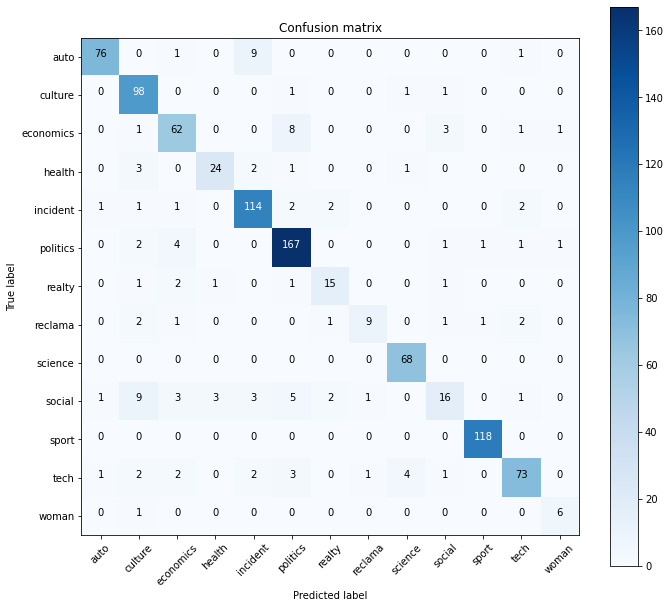

In [20]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [21]:
o = clf.predict(X)

In [22]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [23]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: reclama
predict: economics
Переодень свою мебель 29 ноября 2016 в 9:00 *На правах рекламы Иностранное общество с ограниченной ответственностью "Лангхайнрих Конфекцион Бел" было создано в сентябре 2005 года. ИООО "Лангхайнри...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
Украинцу Виталию Кличко присуждено звание «вечного» чемпиона мира в супертяжелом весе по версии Всемирного боксерского совета (WBC). Церемония награждения Кличко прошла на конгрессе спортивной органи...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
НЬЮ-ЙОРК, 13 декабря. /Корр. ТАСС Кирилл Волков/. Избранный президент США Дональд Трамп провел телефонный разговор с экс-кандидатом на выборах главы государства Миттом Ромни, сообщив ему, что он не бу...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Очередей на установку телефонов скоро не будет В текущем году около 280
тысяч аналоговых номеров телефонов будут заменены на цифровые.Замена
аналоговых станций цифровыми п

In [24]:
# https://habr.com/ru/post/205360/